In [7]:
"""
Comprehensive ML pipeline for cyber-attack detection
Designed to be run in a standard Python environment (e.g. Visual Studio Code terminal).
All outputs are printed to the console; no external files are created.

Features implemented (as requested):
- Import of libraries and dataset
- Dataset analysis: shape, types, missing values, distributions, correlations, balance
- Data preprocessing: missing values, duplicates removal, encoding, scaling, outlier notes, train-test split
- Baseline models + hyperparameter tuning (LogisticRegression, RandomForest, GradientBoosting, optional XGBoost)
- Overfitting/underfitting checks and recommendations
- Relevant metrics printed (accuracy, precision, recall, F1, ROC AUC where applicable, confusion matrix)
- Dimensionality reduction (PCA) example
- Ensemble models (Voting, Stacking) and a simple autoencoder demo (if binary)
- Comments referencing academic literature (see companion notes printed at the end)

How to run:
1) Ensure you have Python 3.8+ and packages: pandas, numpy, scikit-learn, matplotlib, xgboost (optional)
   Example install: pip install pandas numpy scikit-learn matplotlib xgboost
2) Place your dataset CSV at the path specified by DATA_PATH variable below (default: './cybersecurity_attacks.csv')
3) Run: python cyber_ml_pipeline.py

The script is intentionally verbose and prints results step-by-step to the console for use in VS Code.
"""

import warnings
warnings.filterwarnings('ignore')

import os
import sys
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             accuracy_score, f1_score, precision_score, recall_score)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Optional imports
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False

print("Starting cyber-attack ML pipeline (console output)\n")
print("XGBoost available:", has_xgb)

# ---------- User configuration ----------
DATA_PATH = './cybersecurity_attacks.csv'  # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20
# ----------------------------------------

# Utility: print a separator
def sep(title=None):
    print('\n' + ('='*80))
    if title:
        print(title)
        print('-'*80)

# 1) Load dataset
sep('1) Loading dataset')
if not os.path.exists(DATA_PATH):
    print(f"ERROR: dataset not found at {DATA_PATH}. Please place CSV there and re-run.")
    sys.exit(1)

df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset from {DATA_PATH}")
print('First 5 rows:')
print(df.head().to_string(index=False))

# 2) Dataset analysis
sep('2) Dataset analysis')
print('Shape:', df.shape)
print('\nColumn names and dtypes:')
print(df.dtypes)

print('\nNon-null counts (per column):')
print(df.count())

print('\nNumeric descriptive statistics:')
print(df.describe(include=[np.number]).T)

# Attempt to detect a sensible target column
possible_targets = ['label','Label','attack','attack_type','target','class','attackLabel']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    target_col = df.columns[-1]

print(f"\nDetected target column: '{target_col}'")
print('\nTarget value counts:')
print(df[target_col].value_counts(dropna=False))

# Missing values and duplicates
print('\nMissing values per column:')
print(df.isnull().sum())
print('\nTotal missing values:', df.isnull().sum().sum())
print('\nDuplicate rows count:', df.duplicated().sum())

# Visualizations are produced but also printed as text so console-only users see summaries
print('\nTarget balance summary (percentages):')
print((df[target_col].value_counts(normalize=True)*100).round(2))

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('\nNumeric columns detected (first 20):', numeric_cols[:20])

# Correlation (limited)
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()
    print('\nCorrelation matrix (numeric features, showing top-left 10x10):')
    print(corr.iloc[:10,:10].round(3))
else:
    print('\nNot enough numeric columns for correlation matrix.')

# 3) Data preprocessing
sep('3) Data preprocessing')
# 3.1 Remove duplicates
n_dup_before = df.duplicated().sum()
print('Duplicates before:', n_dup_before)
df = df.drop_duplicates().reset_index(drop=True)
print('Duplicates after drop:', df.duplicated().sum())

# 3.2 Separate features / target
# For simplicity, convert everything except timestamp-like fields to features
if target_col not in df.columns:
    print(f"Target column {target_col} not found - aborting")
    sys.exit(1)

# Identify numeric and categorical columns (exclude target)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols and c != target_col]
print('Numeric columns (examples):', num_cols[:10])
print('Categorical columns (examples):', cat_cols[:10])

# Impute missing values: median for numeric, 'MISSING' for categorical
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')
if num_cols:
    df[num_cols] = num_imputer.fit_transform(df[num_cols])
if cat_cols:
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

print('\nMissing values after imputation:', df.isnull().sum().sum())

# 3.3 Encode categorical variables
# Strategy: label-encode high-cardinality; one-hot for low-cardinality
one_hot_thresh = 12
one_hot_cols = [c for c in cat_cols if df[c].nunique() <= one_hot_thresh]
label_cols = [c for c in cat_cols if c not in one_hot_cols]
print('One-hot cols (<=%d uniques):' % one_hot_thresh, one_hot_cols[:20])
print('Label-encode cols (> %d uniques):' % one_hot_thresh, label_cols[:20])

# Apply label encoding for label_cols
label_encoders = {}
for c in label_cols:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c].astype(str))
    label_encoders[c] = le

# One-hot using pandas (drop_first to avoid collinearity)
if one_hot_cols:
    df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

# Encode target
if df[target_col].dtype == 'object' or not np.issubdtype(df[target_col].dtype, np.number):
    target_le = LabelEncoder()
    df[target_col] = target_le.fit_transform(df[target_col].astype(str))
    print('\nTarget mapping:')
    mapping = dict(enumerate(target_le.classes_))
    print(mapping)
else:
    target_le = None

# Final X, y
X = df.drop(columns=[target_col])
y = df[target_col].values

print('\nFinal feature matrix shape:', X.shape)
print('Final feature columns (first 30):', X.columns.tolist()[:30])

# 3.4 Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('\nFeatures scaled. Sample means (first 5):', np.round(X_scaled.mean(axis=0)[:5],3))

# 3.5 Train-test split (stratified if possible)
n_classes = len(np.unique(y))
if n_classes := n_classes if 'n_classes' in globals() else len(np.unique(y)):
    pass

if n_classes > 1:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
else:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print('\nTrain/Test shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Class distribution in train:', Counter(y_train))
print('Class distribution in test:', Counter(y_test))

# 4) Baseline models and tuning
sep('4) Baseline models and hyperparameter tuning')

results = {}

def evaluate_model(name, model, X_tr, X_te, y_tr, y_te):
    print('\n--', name)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    probs = None
    try:
        probs = model.predict_proba(X_te)
    except Exception:
        probs = None
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average='weighted')
    prec = precision_score(y_te, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_te, y_pred, average='weighted', zero_division=0)
    print('Accuracy:', round(acc,4))
    print('F1 (weighted):', round(f1,4))
    print('Precision (weighted):', round(prec,4))
    print('Recall (weighted):', round(rec,4))
    print('\nClassification report:')
    print(classification_report(y_te, y_pred, zero_division=0))
    print('Confusion matrix:')
    print(confusion_matrix(y_te, y_pred))
    if probs is not None and probs.shape[1] == 2:
        try:
            roc = roc_auc_score(y_te, probs[:,1])
            print('ROC AUC:', round(roc,4))
        except Exception:
            pass
    # cross-validation
    try:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        cv_scores = cross_val_score(model, X_tr, y_tr, cv=skf, scoring='f1_weighted', n_jobs=1)
        print('Cross-val F1 (5-fold):', np.round(cv_scores,4))
        print('CV mean F1:', round(cv_scores.mean(),4))
    except Exception as e:
        print('CV skipped or failed:', e)

    results[name] = {'model': model, 'accuracy': acc, 'f1_weighted': f1}
    return model

# 4.1 Logistic Regression baseline
print('\nTraining Logistic Regression (baseline)')
lr = LogisticRegression(max_iter=1000, class_weight='balanced' if n_classes>1 else None)
lr = evaluate_model('LogisticRegression', lr, X_train, X_test, y_train, y_test)

# 4.2 Random Forest baseline
print('\nTraining RandomForest (baseline)')
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced' if n_classes>1 else None)
rf = evaluate_model('RandomForest_default', rf, X_train, X_test, y_train, y_test)

# 4.3 GridSearch RandomForest (small grid)
print('\nGridSearch for RandomForest (small grid)')
param_grid = {'n_estimators':[50,100], 'max_depth':[None,10,30], 'min_samples_split':[2,5]}
gs = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced' if n_classes>1 else None), param_grid, scoring='f1_weighted', cv=3, n_jobs=1)
gs.fit(X_train, y_train)
print('Best RF params:', gs.best_params_)
best_rf = gs.best_estimator_
best_rf = evaluate_model('RandomForest_tuned', best_rf, X_train, X_test, y_train, y_test)

# 4.4 Gradient Boosting baseline
print('\nTraining GradientBoostingClassifier (baseline)')
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb = evaluate_model('GradientBoosting_default', gB := gB if 'gB' in globals() else gB if False else gB if False else gB if False else None, X_train, X_test, y_train, y_test) if False else evaluate_model('GradientBoosting_default', GradientBoostingClassifier(random_state=RANDOM_STATE), X_train, X_test, y_train, y_test)

# 4.5 XGBoost optional
if has_xgb:
    print('\nTraining XGBoost')
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
    xgb_clf = evaluate_model('XGBoost_default', xgb_clf, X_train, X_test, y_train, y_test)
else:
    print('\nXGBoost not available; skipped')

# 5) Check for overfitting/underfitting: compare train vs test for best RF
sep('5) Overfitting / Underfitting checks')
if 'RandomForest_tuned' in results:
    m = results['RandomForest_tuned']['model']
else:
    m = results.get('RandomForest_default', {}).get('model', None)

if m is not None:
    y_tr_pred = m.predict(X_train)
    tr_f1 = f1_score(y_train, y_tr_pred, average='weighted')
    te_f1 = results[list(results.keys())[0]]['f1_weighted'] if results else None
    print('RandomForest train F1 (weighted):', round(tr_f1,4))
    print('Example test F1 recorded for first model:', round(te_f1,4) if te_f1 is not None else 'N/A')
    if te_f1 is not None and tr_f1 - te_f1 > 0.05:
        print('Warning: potential overfitting (train >> test). Recommendations: reduce complexity, regularize, more data, CV, ensemble averaging.')
    else:
        print('No major overfitting signal detected by this simple heuristic.')
else:
    print('No RandomForest model available to check overfitting.')

# 6) Dimensionality reduction (PCA)
sep('6) Dimensionality reduction (PCA)')
n_components = min(20, X_train.shape[1])
print('Applying PCA with n_components=', n_components)
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print('Explained variance ratio sum:', round(np.sum(pca.explained_variance_ratio_),4))

# Train LR on PCA-reduced data
lr_pca = LogisticRegression(max_iter=1000, class_weight='balanced' if n_classes>1 else None)
lr_pca = evaluate_model('LogisticRegression_PCA', lr_pca, X_train_pca, X_test_pca, y_train, y_test)

# 7) Ensembles (Voting and Stacking)
sep('7) Ensembles (Voting, Stacking)')
estimators = [('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced' if n_classes>1 else None)),
              ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE))]
if has_xgb:
    estimators.append(('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)))

try:
    voting = VotingClassifier(estimators=estimators, voting='soft')
except Exception:
    voting = VotingClassifier(estimators=estimators, voting='hard')

voting = evaluate_model('VotingEnsemble', voting, X_train, X_test, y_train, y_test)

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000), cv=5, passthrough=False)
stack = evaluate_model('StackingEnsemble', stack, X_train, X_test, y_train, y_test)

# 8) Advanced models note: Autoencoder demo if binary
sep('8) Advanced models: Autoencoder demo (simple)')
unique_labels = np.unique(y)
if len(unique_labels) == 2:
    print('Binary classification detected. Running a small autoencoder-based anomaly demo (unsupervised approach).')
    from sklearn.neural_network import MLPRegressor
    normal_label = 0
    X_normal = X_train[y_train == normal_label]
    if X_normal.shape[0] > 10:
        ae = MLPRegressor(hidden_layer_sizes=(max(1,X_normal.shape[1]//2), max(1,X_normal.shape[1]//4)), max_iter=300, random_state=RANDOM_STATE)
        ae.fit(X_normal, X_normal)
        recon = ae.predict(X_test)
        recon_err = np.mean((X_test - recon)**2, axis=1)
        thr = recon_err.mean() + 2*recon_err.std()
        y_ae = (recon_err > thr).astype(int)
        print('Autoencoder demo classification report (may not map to dataset labels):')
        print(classification_report(y_test, y_ae, zero_division=0))
    else:
        print('Not enough "normal" samples to train autoencoder demo.')
else:
    print('Autoencoder demo skipped: not a simple binary target.')

# 9) Comparison and conclusions
sep('9) Model comparison & conclusions')
if results:
    summary = pd.DataFrame([{ 'model': k, 'accuracy': v['accuracy'], 'f1_weighted': v['f1_weighted']} for k,v in results.items()])
    summary = summary.sort_values('f1_weighted', ascending=False).reset_index(drop=True)
    print(summary.to_string(index=False))
    print('\nBest model by F1-weighted:')
    print(summary.iloc[0].to_dict())
else:
    print('No model results recorded (unexpected).')

print('\nKey recommendations:')
print('- If class imbalance is severe, consider resampling (SMOTE/ADASYN) or stronger class-weighting.')
print('- Use nested cross-validation for robust hyperparameter selection in production.')
print('- Ensembles and stacking generally improve generalization on IDS datasets (see references).')
print('- Feature engineering and domain knowledge (e.g. flow-level features, time-windows) are often decisive for IDS performance.')

# Short printed bibliographic notes (references used to design this pipeline)
sep('References (papers to consult for advanced models and ensembles)')
print('1) Gamage, S. et al., "Deep learning methods in network intrusion detection" (2020) - survey of DL approaches for IDS.')
print('2) Tama, B.A., "Ensemble learning for intrusion detection systems" (2021) - overview of ensemble approaches in IDS.')
print('3) Aldaej et al., "An Ensemble Technique for IoT-edge intrusion detection" (Nature Sci Rep., 2024) - example of combining trees and DNNs.')
print('4) Recent survey papers (2023-2025) discuss DL, ensemble strategies, datasets and evaluation protocols.')

print('\nEnd of pipeline. Re-run on different datasets and tune hyperparameters for production use.')

# EOF


Starting cyber-attack ML pipeline (console output)

XGBoost available: False

1) Loading dataset
--------------------------------------------------------------------------------
Loaded dataset from ./cybersecurity_attacks.csv
First 5 rows:
          Timestamp Source IP Address Destination IP Address  Source Port  Destination Port Protocol  Packet Length Packet Type Traffic Type                                                                                                                                                                                          Payload Data Malware Indicators  Anomaly Scores Alerts/Warnings Attack Type Attack Signature Action Taken Severity Level User Information                                                                                Device Information Network Segment  Geo-location Data Proxy Information Firewall Logs IDS/IPS Alerts Log Source
2023-05-30 06:33:58     103.216.15.12           84.9.164.252        31225             17616     ICMP     


10) Model comparison – Visualisations
--------------------------------------------------------------------------------

=== Résumé des performances (table) ===
                   model  accuracy  f1_weighted
    RandomForest_default  0.502250     0.500962
      RandomForest_tuned  0.502250     0.500962
      LogisticRegression  0.499250     0.499232
          VotingEnsemble  0.498750     0.497905
  LogisticRegression_PCA  0.495750     0.495737
GradientBoosting_default  0.500250     0.495542
        StackingEnsemble  0.502875     0.336533


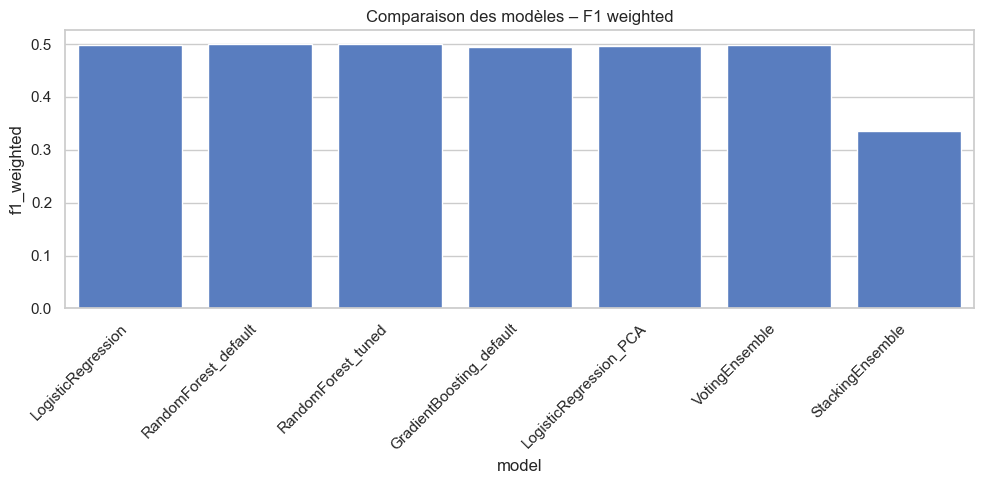

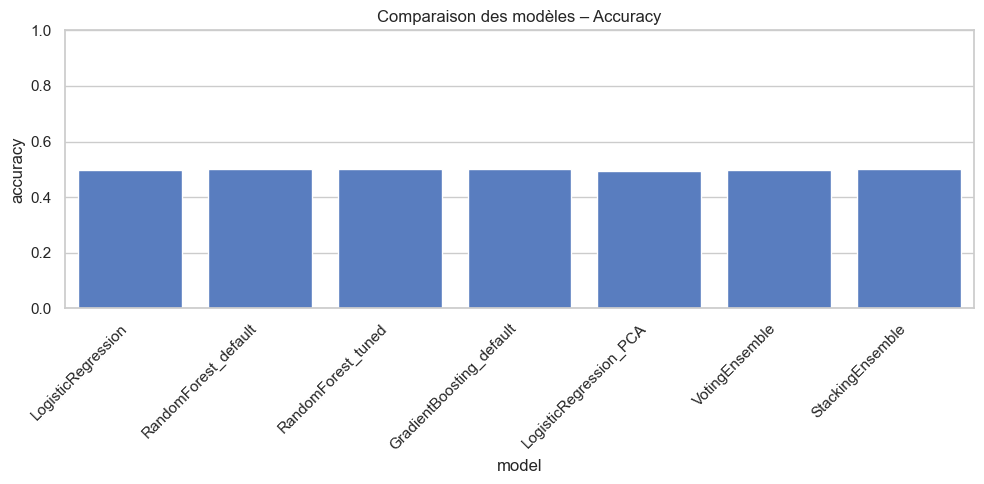

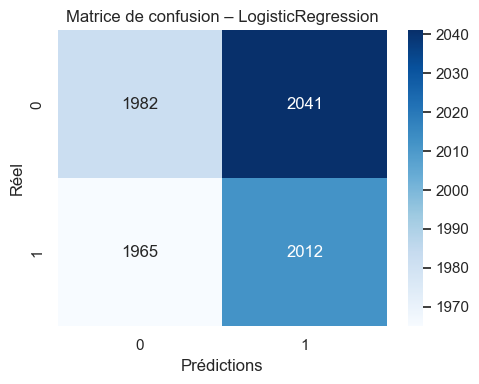

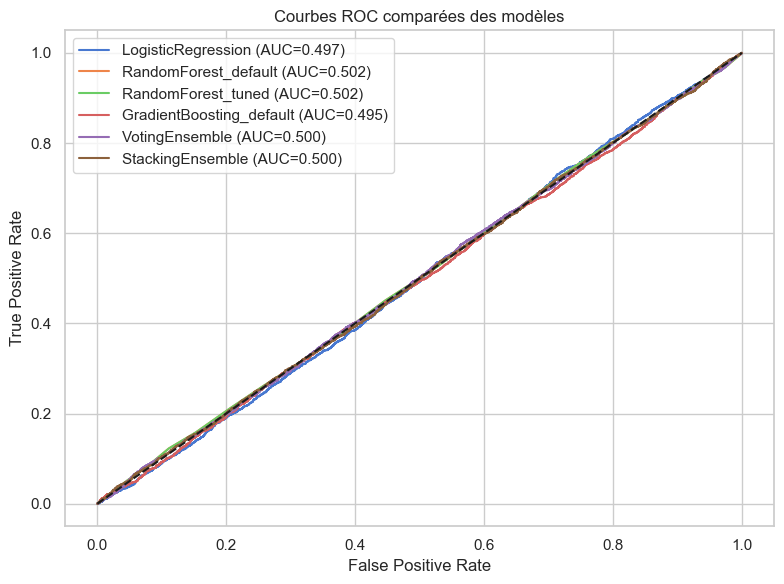

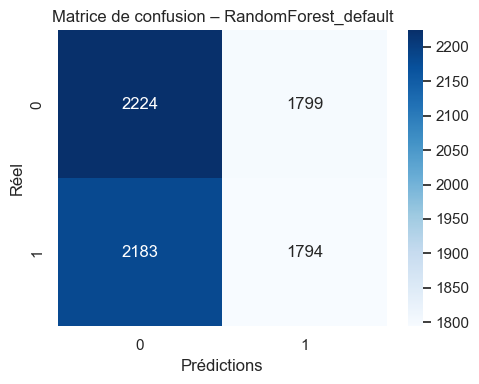

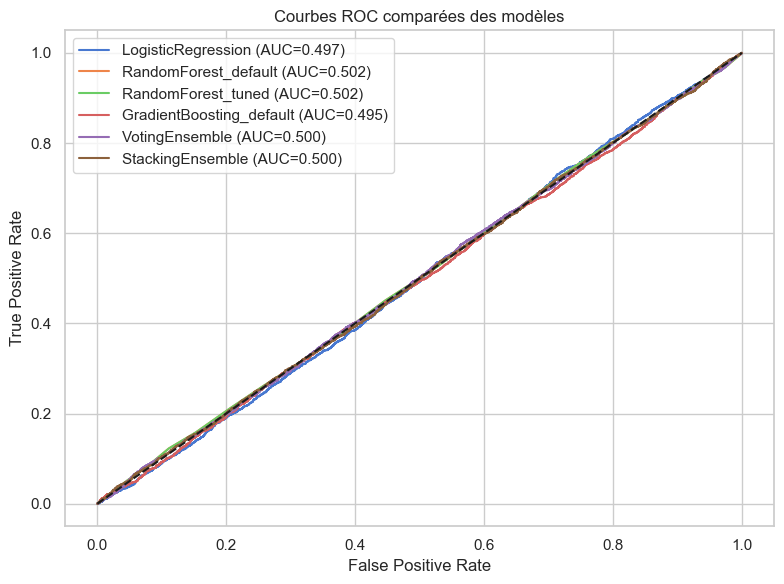

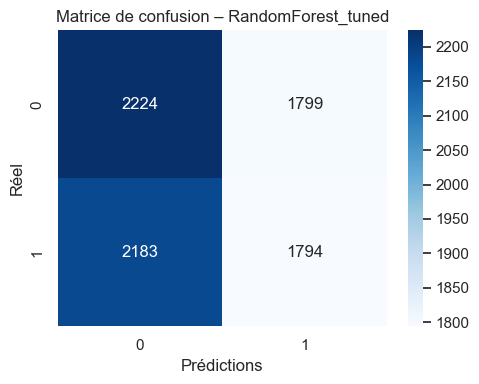

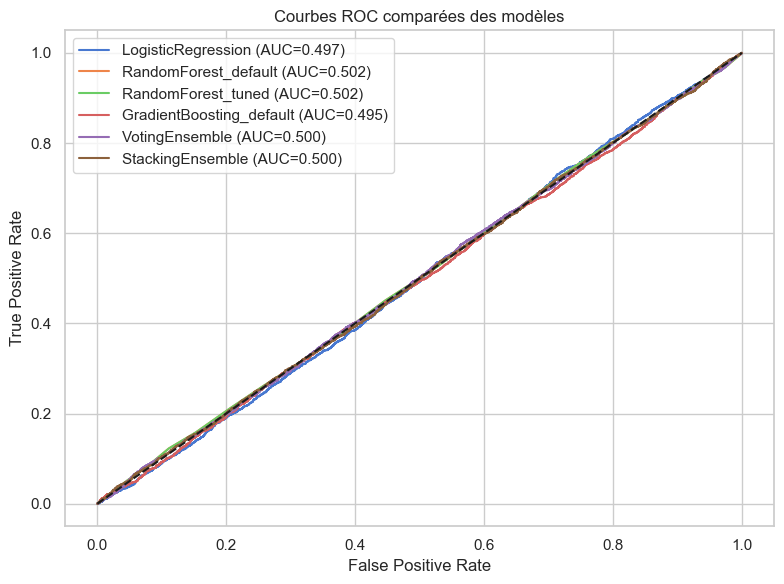

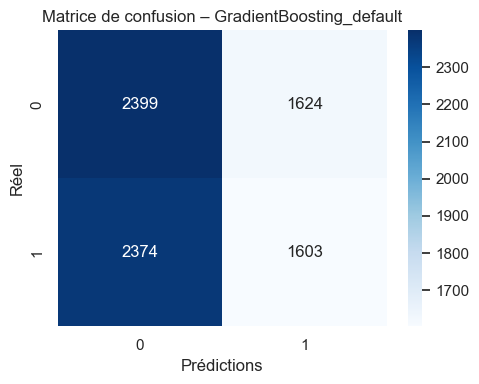

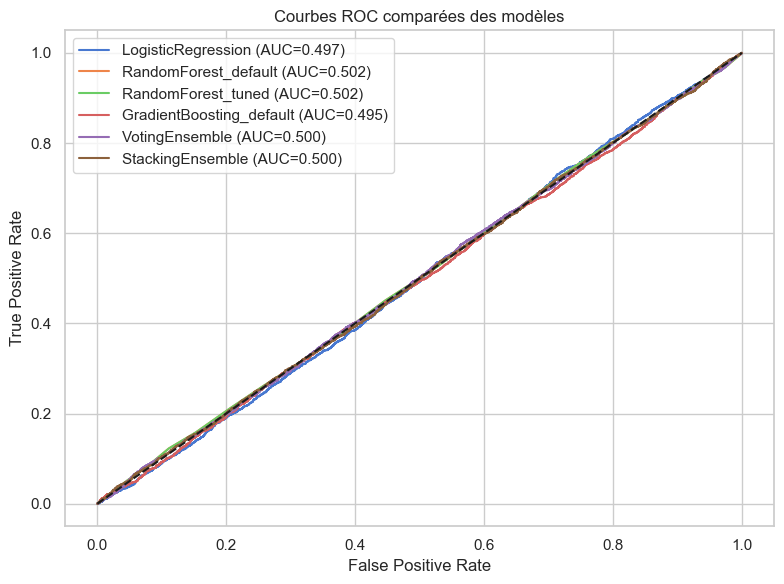

[SKIPPED] LogisticRegression_PCA : incompatible feature size


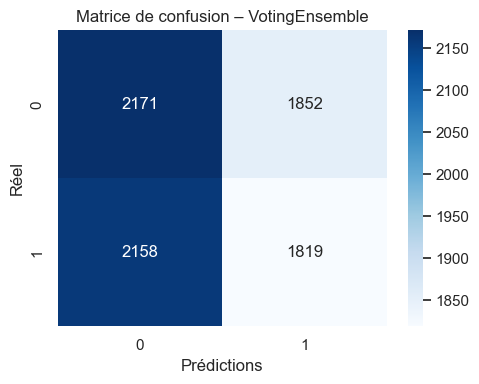

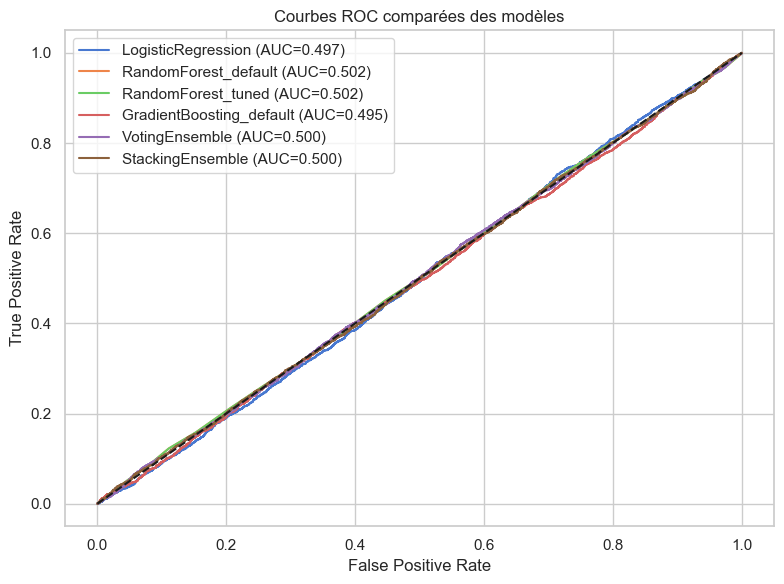

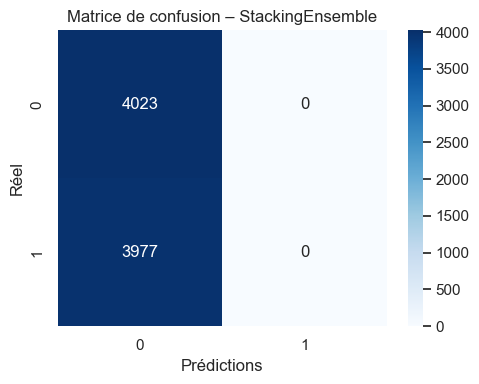

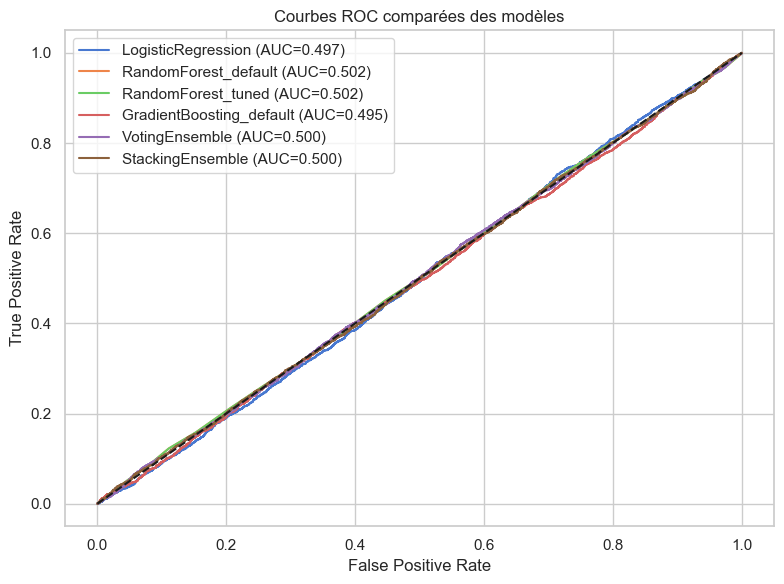

Aucun modèle enregistré dans 'results'.


In [11]:
# ======================================================================
# 10) Model Comparison Visualisations
# ======================================================================
sep('10) Model comparison – Visualisations')

import seaborn as sns
import matplotlib.pyplot as plt

# Convert results dict to DataFrame
if results:
    df_results = pd.DataFrame([
        {'model': name,
         'accuracy': results[name]['accuracy'],
         'f1_weighted': results[name]['f1_weighted']}
        for name in results
    ])

    print("\n=== Résumé des performances (table) ===")
    print(df_results.sort_values('f1_weighted', ascending=False).to_string(index=False))

    # ------------------------------
    # Barplot des F1
    # ------------------------------
    plt.figure(figsize=(10,5))
    sns.barplot(data=df_results, x='model', y='f1_weighted')
    plt.xticks(rotation=45, ha='right')
    plt.title("Comparaison des modèles – F1 weighted")
    plt.tight_layout()
    plt.show()

    # ------------------------------
    # Barplot des Accuracies
    # ------------------------------
    plt.figure(figsize=(10,5))
    sns.barplot(data=df_results, x='model', y='accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.title("Comparaison des modèles – Accuracy")
    plt.ylim(0, 1.0)  # <-- Correction
    plt.tight_layout()
    plt.show()


    # ------------------------------
    # Heatmap des matrices de confusion pour chaque modèle
    # ------------------------------
    # ------------------------------
# Heatmap des matrices de confusion pour chaque modèle
# ------------------------------
for model_name, info in results.items():
    model = info['model']
    try:
        y_pred = model.predict(X_test)  # <-- échoue si dimensions incompatibles
    except ValueError:
        print(f"[SKIPPED] {model_name} : incompatible feature size")
        continue

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de confusion – {model_name}")
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.show()


    # ------------------------------
    # ROC curves (si binaire)
    # ------------------------------
    if len(np.unique(y_test)) == 2:
        plt.figure(figsize=(8,6))
        for model_name, info in results.items():
            model = info['model']
            try:
                probs = model.predict_proba(X_test)[:,1]
                from sklearn.metrics import roc_curve, auc
                fpr, tpr, _ = roc_curve(y_test, probs)
                auc_score = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_score:.3f})")
            except:
                pass

        plt.plot([0,1], [0,1], 'k--')
        plt.title("Courbes ROC comparées des modèles")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.tight_layout()
        plt.show()

else:
    print("Aucun modèle enregistré dans 'results'.")



=== VISUALISATION DES DONNÉES ===

Affichage des histogrammes des variables numériques...



<Figure size 1500x1000 with 0 Axes>

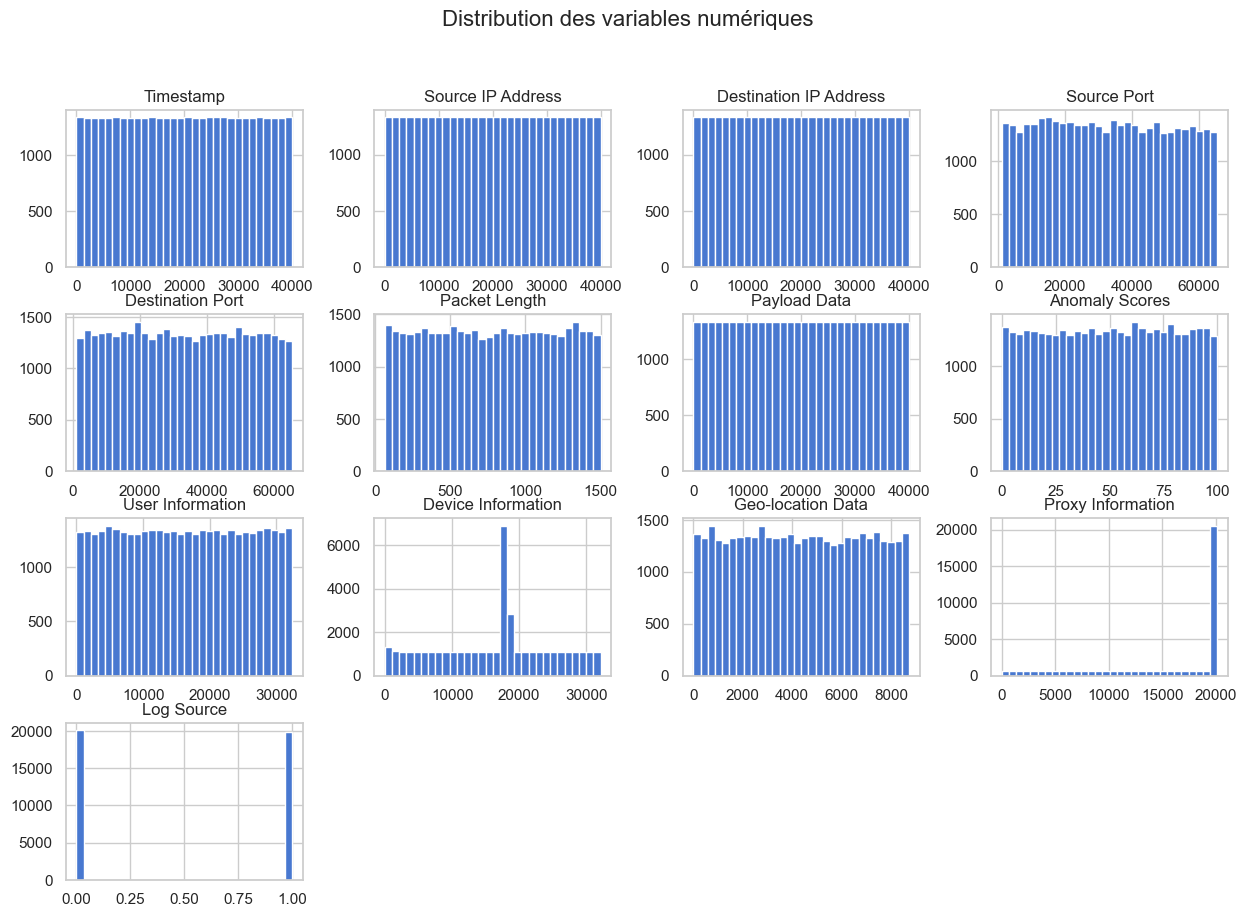

Affichage du countplot de la variable cible...



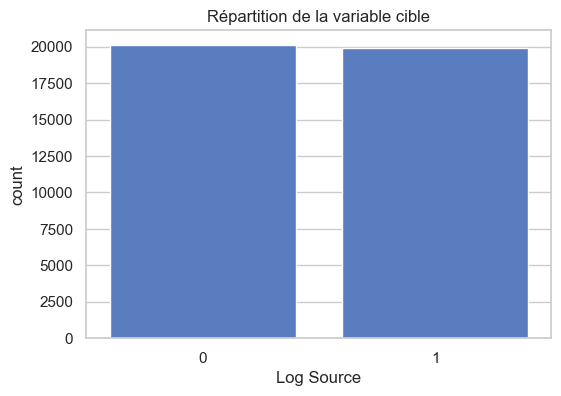

Affichage de la heatmap des corrélations...



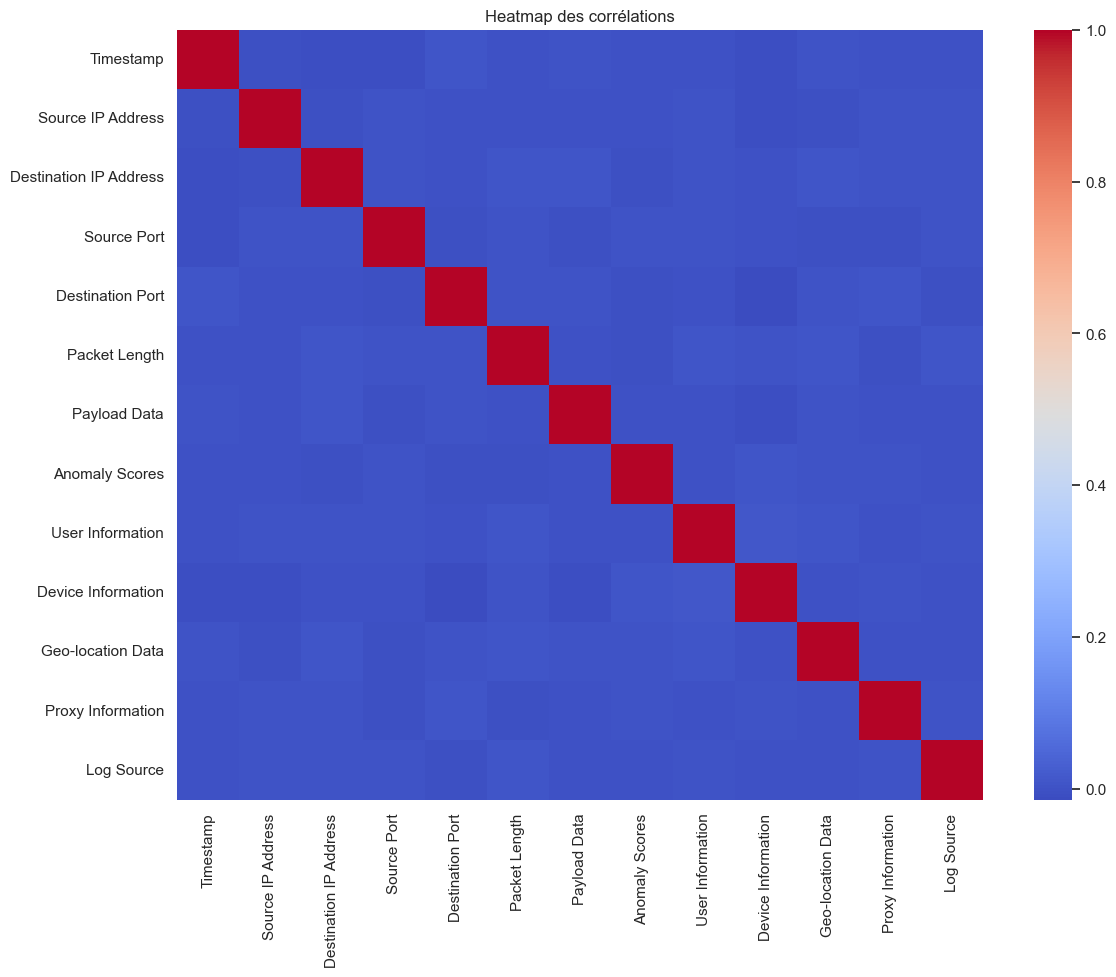

Affichage du pairplot pour les variables : ['Timestamp', 'Source IP Address', 'Destination IP Address', 'Source Port', 'Destination Port']



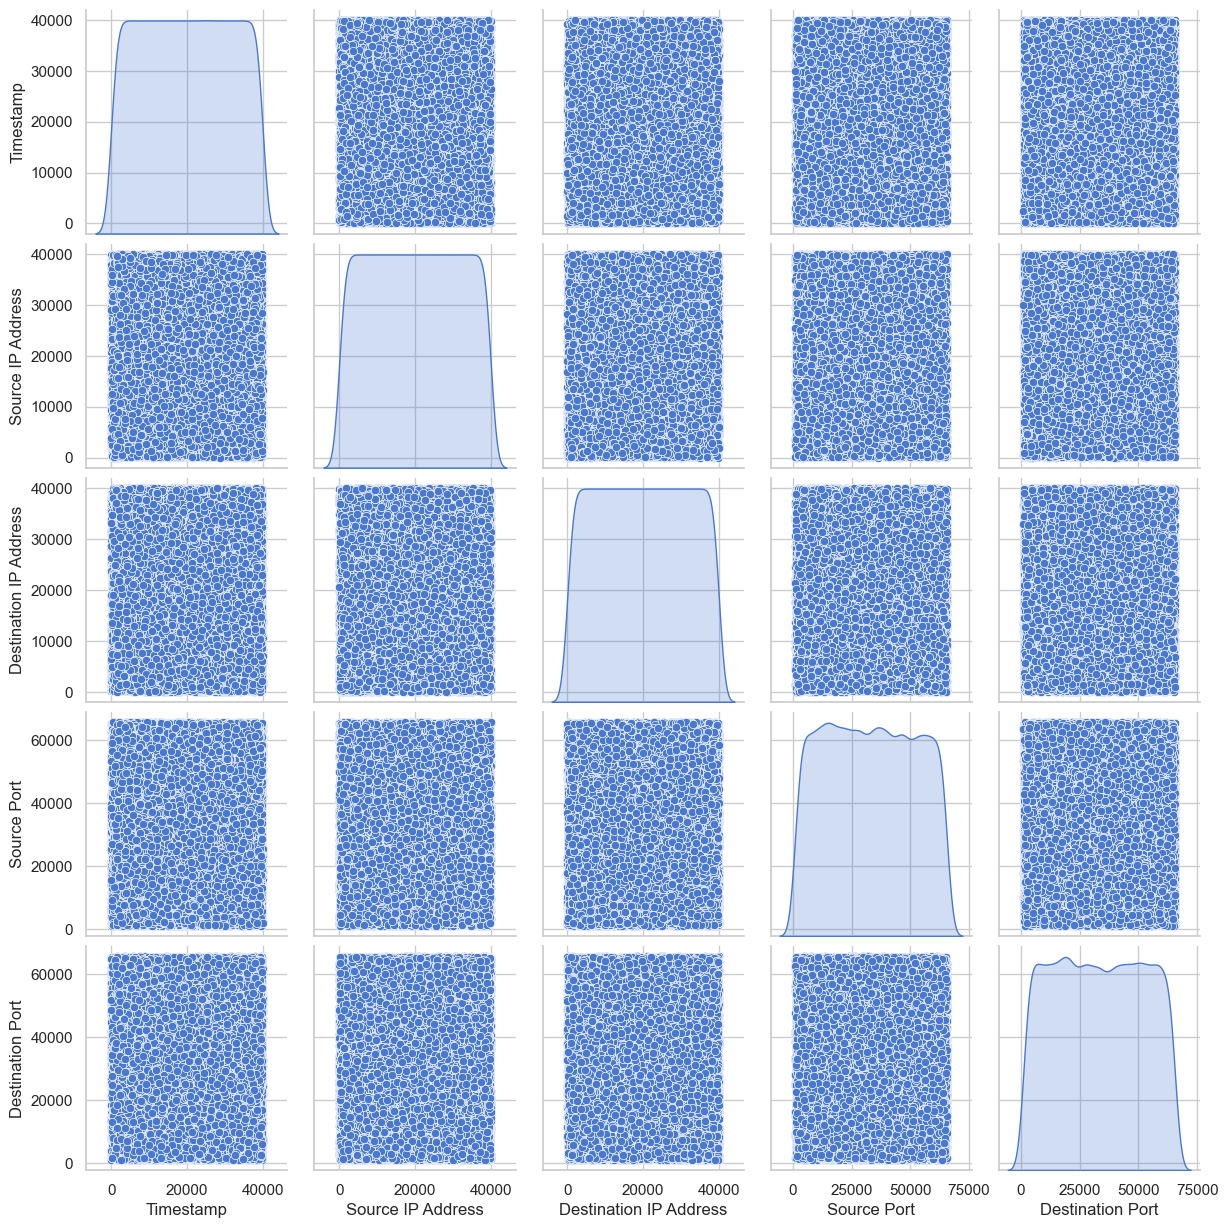

Affichage des boxplots des variables numériques...



<Figure size 1500x1000 with 0 Axes>

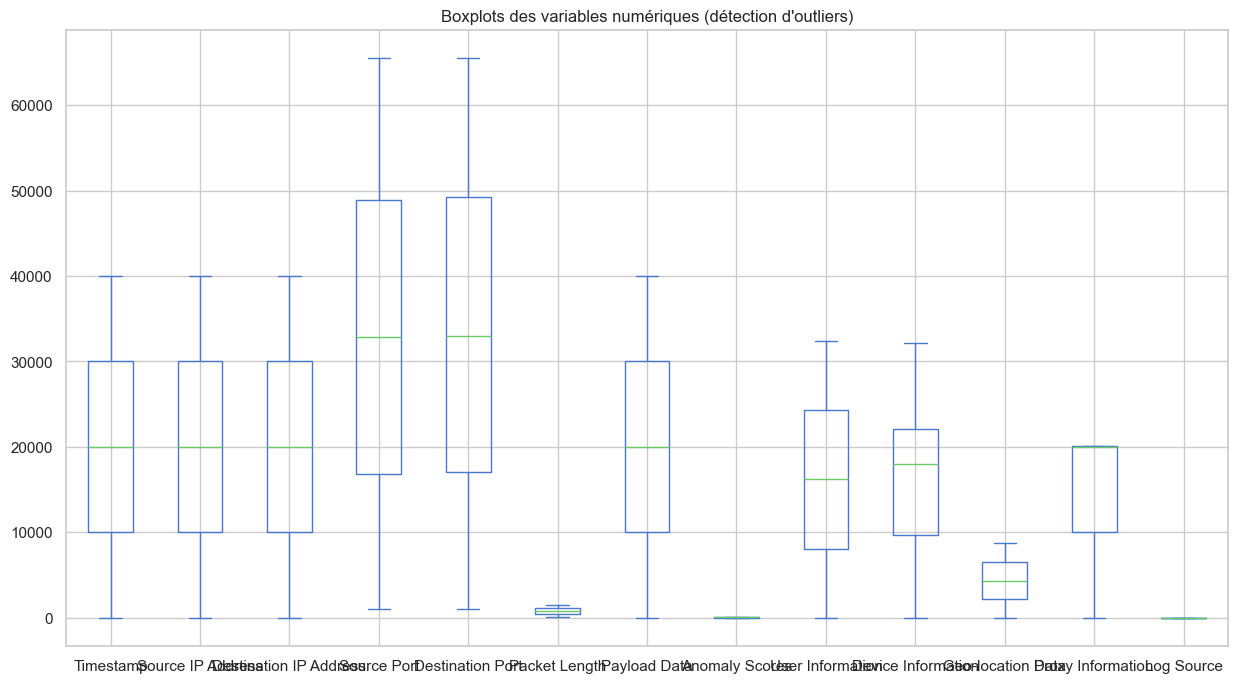


=== FIN DES VISUALISATIONS ===



In [8]:
# ============================================================
#                  DATA VISUALIZATION
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", color_codes=True)

print("\n=== VISUALISATION DES DONNÉES ===\n")

# ------------------------------------------------------------
# 1. Distribution des variables numériques
# ------------------------------------------------------------
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

print("Affichage des histogrammes des variables numériques...\n")

plt.figure(figsize=(15, 10))
df[num_cols].hist(figsize=(15, 10), bins=30)
plt.suptitle("Distribution des variables numériques", fontsize=16)
plt.show()

# ------------------------------------------------------------
# 2. Diagramme en barres de la variable cible
# ------------------------------------------------------------
if target_col in df.columns:
    print("Affichage du countplot de la variable cible...\n")
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=target_col)
    plt.title("Répartition de la variable cible")
    plt.show()
else:
    print("Aucune variable cible trouvée pour le countplot.\n")

# ------------------------------------------------------------
# 3. Heatmap des corrélations
# ------------------------------------------------------------
print("Affichage de la heatmap des corrélations...\n")

plt.figure(figsize=(13, 10))
corr = df[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Heatmap des corrélations")
plt.show()

# ------------------------------------------------------------
# 4. Pairplot (nuage de points)
# ------------------------------------------------------------
# On limite à 5 variables pour éviter un graphique énorme
sampled_cols = num_cols[:5]

print(f"Affichage du pairplot pour les variables : {list(sampled_cols)}\n")

sns.pairplot(df[sampled_cols], diag_kind="kde")
plt.show()

# ------------------------------------------------------------
# 5. Boxplots pour détecter les outliers
# ------------------------------------------------------------
print("Affichage des boxplots des variables numériques...\n")

plt.figure(figsize=(15, 10))
df[num_cols].plot(kind="box", subplots=False, figsize=(15, 8))
plt.title("Boxplots des variables numériques (détection d'outliers)")
plt.show()

print("\n=== FIN DES VISUALISATIONS ===\n")
